from:

https://keras.io/examples/timeseries/timeseries_classification_transformer/

In [10]:
import os
import pathlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn.utils import class_weight

from tensorflow import keras
from tensorflow.keras import layers

from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [11]:
train_df = pd.read_csv('/kaggle/input/smit-tgt-2023/data/train.csv')
test_df = pd.read_csv('/kaggle/input/smit-tgt-2023/data/test.csv')
submit_df = pd.read_csv('/kaggle/input/smit-tgt-2023/data/submission_sample.csv')

DS

In [12]:
def get_data_example(row):
#     return (row[:-1][:, None], row[-1])
    return (row[:-1][:, None], row[-1])
            
def get_data_example_test(row):
    return row[:, None]

In [23]:
full_ds = tf.data.Dataset.from_tensor_slices(train_df.fillna(0).values)
full_ds = full_ds.map(get_data_example)

test_ds = full_ds.take(750) 
train_ds = full_ds.skip(750)
print(train_ds.cardinality().numpy(), test_ds.cardinality().numpy())

train_ds = train_ds.batch(256).cache().shuffle(3000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(256).cache().prefetch(tf.data.AUTOTUNE)

submit_ds = tf.data.Dataset.from_tensor_slices((test_df.fillna(0).values))
submit_ds = submit_ds.map(get_data_example_test)
submit_ds = submit_ds.batch(256)
print(train_ds.take(2))

3042 750
<TakeDataset element_spec=(TensorSpec(shape=(None, 300, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [14]:
next(train_ds.as_numpy_iterator())[0][0];

In [15]:
next(train_ds.as_numpy_iterator());

Model

In [20]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [24]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [28]:
input_shape = (300, 1)

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=1, #4
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), # 'binary_crossentropy'
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 300, 1)]     0           []                               
                                                                                                  
 multi_head_attention_20 (Multi  (None, 300, 1)      7169        ['input_6[0][0]',                
 HeadAttention)                                                   'input_6[0][0]']                
                                                                                                  
 dropout_42 (Dropout)           (None, 300, 1)       0           ['multi_head_attention_20[0][0]']
                                                                                                  
 layer_normalization_40 (LayerN  (None, 300, 1)      2           ['dropout_42[0][0]']       

In [26]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df['label']),
                                                 y=train_df['label'])
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [37]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=400,
    batch_size=256,
    callbacks=callbacks,
    class_weight = class_weights
)

Epoch 1/400
12/12 [==============================] - 2s 140ms/step - loss: 0.1680 - accuracy: 0.9346 - val_loss: 0.2417 - val_accuracy: 0.8973
Epoch 2/400
12/12 [==============================] - 2s 140ms/step - loss: 0.1669 - accuracy: 0.9352 - val_loss: 0.2414 - val_accuracy: 0.8973
Epoch 3/400
12/12 [==============================] - 2s 140ms/step - loss: 0.1690 - accuracy: 0.9316 - val_loss: 0.2400 - val_accuracy: 0.8973
Epoch 4/400
12/12 [==============================] - 2s 140ms/step - loss: 0.1646 - accuracy: 0.9369 - val_loss: 0.2390 - val_accuracy: 0.8973
Epoch 5/400
12/12 [==============================] - 2s 143ms/step - loss: 0.1648 - accuracy: 0.9306 - val_loss: 0.2386 - val_accuracy: 0.9000
Epoch 6/400
12/12 [==============================] - 2s 139ms/step - loss: 0.1649 - accuracy: 0.9320 - val_loss: 0.2391 - val_accuracy: 0.8973
Epoch 7/400
12/12 [==============================] - 2s 141ms/step - loss: 0.1610 - accuracy: 0.9303 - val_loss: 0.2362 - val_accuracy: 0.9000

Text(0, 0.5, 'Accuracy [%]')

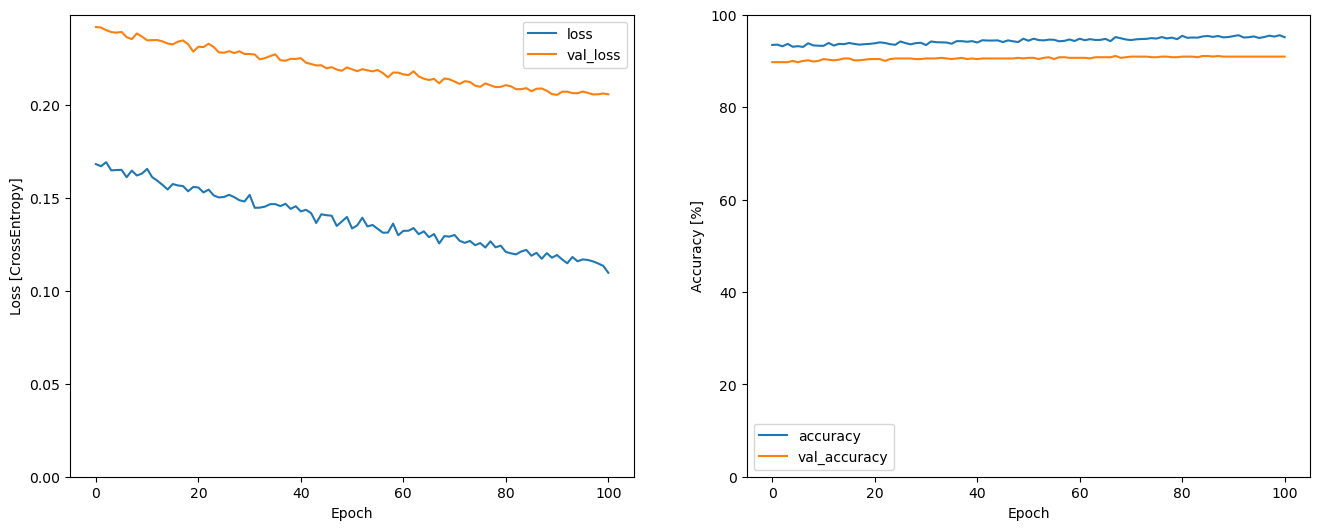

In [38]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [39]:
model.evaluate(test_ds, verbose=1)

3/3 [==============================] - 0s 50ms/step - loss: 0.2052 - accuracy: 0.9093


[0.20520861446857452, 0.909333348274231]

Submit

In [40]:
submit_preds = model.predict(submit_ds)

submit_df['label'] = tf.where(submit_preds < 0.5, 0, 1).numpy()[:, 0]
submit_df.to_csv('./keras_tr.csv', index=False)

2/2 [==============================] - 0s 49ms/step
